# Predicting house prices using k-nearest neighbors regression


# Fire up GraphLab Create

In [1]:
import graphlab

# Load in house sales data

For this notebook, we use a subset of the King County housing dataset created by randomly selecting 40% of the houses in the full dataset.

In [2]:
sales = graphlab.SFrame('kc_house_data_small.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to nanlee_89@yahoo.com and will expire on December 07, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\Nan\AppData\Local\Temp\graphlab_server_1529603737.log.0


### Import Numpy

In [3]:
import numpy as np 

### Function to convert SFrame to Numpy data

In [4]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # add a constant column to an SFrame
    
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # combine two lists
    
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    
    # convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    
    # convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

###  Function to normalize features of the matrix

In [5]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    features = feature_matrix/norms
    return features, norms

# Split data into training, test, and validation sets

In [6]:
(train_and_validation, test) = sales.random_split(.8, seed=1) # initial train/test split
(train, validation) = train_and_validation.random_split(.8, seed=1) # split training set into training and validation sets

# Extract features and normalize

### __Using all of the numerical inputs listed in `feature_list`, transform the training, test, and validation SFrames into Numpy arrays:__

In [7]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

### __Divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.__

In [8]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

# Compute a single distance

Explore computing the "distance" between two given houses.  We will take our **query house** to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

Check the features associated with the query house, print the first row (index 0) of the test feature matrix. 

In [9]:
features_test[0]

array([ 0.01345102,  0.01551285,  0.01807473,  0.01759212,  0.00160518,
        0.017059  ,  0.        ,  0.05102365,  0.0116321 ,  0.01564352,
        0.01362084,  0.02481682,  0.01350306,  0.        ,  0.01345386,
       -0.01346927,  0.01375926,  0.0016225 ])

The 10th row (index 9) of the training feature matrix.

In [10]:
features_train[9]

array([ 0.01345102,  0.01163464,  0.00602491,  0.0083488 ,  0.00050756,
        0.01279425,  0.        ,  0.        ,  0.01938684,  0.01390535,
        0.0096309 ,  0.        ,  0.01302544,  0.        ,  0.01346821,
       -0.01346254,  0.01195898,  0.00156612])

***The Euclidean distance between the query house and the 10th house of the training set  ***




In [11]:
np.sqrt(np.sum((features_train[9]-features_test[0])**2))

0.059723593716661257

# Compute multiple distances

To do nearest neighbor regression, we need to compute the distance between our query house and *all* houses in the training set.  

To visualize this nearest-neighbor search, we'll first compute the distance from our query house (`features_test[0]`) to the **first 10 houses** of the training set (`features_train[0:10]`) and then search for the nearest neighbor within this small set of houses.  Through restricting ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.


In [12]:
# following loop computes the Euclidean distance from the query house to each of the first 10 houses in the training set.

multiple_distance = []
for training_house in features_train[0:10]:
     multiple_distance.append(np.sqrt(np.sum((training_house-features_test[0])**2)))

### *** Among the first 10 training houses,  house that is the closest to the query house ***



In [13]:
multiple_distance = np.array(multiple_distance)
multiple_distance.argmin()

8

It is computationally inefficient to loop over computing distances to all houses in our training dataset. Fortunately, many of the Numpy functions can be **vectorized**, applying the same operation over multiple values or vectors. 

# Perform 1-nearest neighbor regression

Now that we have the element-wise differences, it is not too hard to compute the Euclidean distances between our query house and all of the training houses. 

### __First, calculate the difference between the features of the query house and the `i`-th training house.__

In [14]:
diff = features_train - features_test[0]

### __Second, compute the Euclidean distances between the query house and all houses in the training set. __ 

In [15]:
# take these feature-by-feature differences in diff, square each, and take the sum over feature indices. 
distances = np.sqrt(np.sum(diff**2,axis=1))

###  Function that computes the distances from a query house to all training houses. 

In [16]:
def get_distances(training_features_matrix, single_feature_vector):
    diff = training_features_matrix - single_feature_vector
    distances = np.sqrt(np.sum(diff**2,axis=1))
    return distances

### __Compute 1 nearest neighbor regression for a single query house__

In [17]:
distances_to_third_house = get_distances(features_train, features_test[2])

In [18]:
np.argsort(distances_to_third_house)

array([ 382, 1149, 4087, ..., 1107, 5226, 2486], dtype=int64)

In [19]:
## the index of the house in the training set that is closest to this query house
np.argmin(distances_to_third_house)

382

### __Predicted value of the query house based on 1-nearest neighbor regression?__

In [20]:
## predicted value of the query house based on 1-nearest neighbor regression
output_train[382]

249000

# Perform k-nearest neighbor regression

### Function to calculate the k-nearest neighbors of a single query house

In [21]:
def get_distances_k_nearest_neighbors(k, training_features_matrix, single_feature_vector):
    diff = training_features_matrix - single_feature_vector
    distances = np.sqrt(np.sum(diff**2,axis=1))
    nearest_neighbors = np.argsort(distances)
    return nearest_neighbors[0:k]

### __  Compute k-nearest neighbors of a single query house__

In [22]:
n = get_distances_k_nearest_neighbors(4, features_train, features_test[2])

In [23]:
n

array([ 382, 1149, 4087, 3142], dtype=int64)

## Make a single prediction by averaging k nearest neighbor outputs

### Function to predict price of a house using k-nearest neighbors

In [24]:
def predict_output_k_nearest_neighbors(k, training_features_matrix, training_outputs, single_feature_vector):
    
    diff = training_features_matrix - single_feature_vector
    distances = np.sqrt(np.sum(diff**2,axis=1))
    nearest_neighbors = np.argsort(distances)
    
    return np.mean(training_outputs[nearest_neighbors[0:k]])

### __Predict the value of the query house using k-nearest neighbors with `k=4` and the simple averaging method described and implemented above.__

In [25]:
predict_output_k_nearest_neighbors(4, features_train, output_train, features_test[2])

413987.5

Compare this predicted value using 4-nearest neighbors to the predicted value using 1-nearest neighbor computed earlier. It is clear that the 4-nearest neighbors gives us a much reasonable price estimate.

## Make multiple predictions

### Function to predict prices of multiple houses using k-nearest neighbors

In [26]:
def predict_multiple_output_k_nearest_neighbors(k, training_features_matrix, training_outputs, query_feature_matrix):
    predicted_house_price = []
    for i in range(query_feature_matrix.shape[0]):
        diff = training_features_matrix - query_feature_matrix[i]
        distances = np.sqrt(np.sum(diff**2,axis=1))
        nearest_neighbors = np.argsort(distances)
        prediction = np.mean(training_outputs[nearest_neighbors[0:k]])
        predicted_house_price.append(prediction)
    return np.array(predicted_house_price)

### ** Make predictions for the first 10 houses in the test set using k-nearest neighbors with `k=10`. **

In [27]:
prediction_test = predict_multiple_output_k_nearest_neighbors(10, features_train, output_train, features_test[0:9])

In [28]:
# the index of the house in this query set that has the lowest predicted value
prediction_test.argmin()

6

In [29]:
# the predicted value of this house

prediction_test[6]

350032.0

## Choosing the best value of k using a validation set

In [33]:
rss_all = []
for k in range(1,16):
    prediction = predict_multiple_output_k_nearest_neighbors(k, features_train, output_train,  features_valid)
    residual = prediction - output_valid
    rss = (residual**2).sum()
    rss_all.append(rss)

__To visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:__

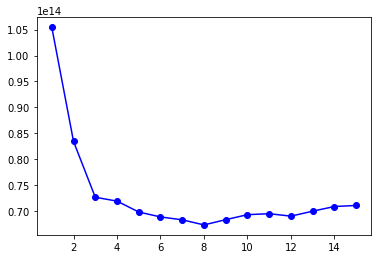

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')

__ Best value of k produced the lowest RSS on VALIDATION set. __

In [41]:
for k, rss in zip(kvals, rss_all):
    if rss == min(rss_all):
        k_best = k

k_best

8

** RSS on the TEST data using the value of k found above **

In [43]:
prediction_test = predict_multiple_output_k_nearest_neighbors(k, features_train, output_train,  features_test)
rss_test = ((prediction_test - output_test)**2).sum()
print rss_test

1.34342939295e+14
